In [1]:
import pandas as pd
import numpy as np
from math import log2

# Untuk pemodelan & visualisasi scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import matplotlib.pyplot as plt

In [2]:
# Dataset Play Golf (Sama seperti di slide 17)
# Total 14 data: 9 'Yes' dan 5 'No'
data = {
 'Outlook': ['Rainy', 'Rainy', 'Overcast', 'Sunny', 'Sunny', 'Sunny', 'Overcast', 'Rainy', 'Rainy', 'Sunny', 'Rainy', 'Overcast', 'Overcast', 'Sunny'],
 'Temp': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
 'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
 'Windy': [False, True, False, False, False, True, True, False, False, False, True, True, False, True],
 'PlayGolf': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
    # Note: data di slide 17 baris ke-11 (Rainy, Mild, Normal, True) adalah 'Yes'
    # Kode asli Anda menuliskannya 'No' di JSON, saya ganti 'Yes' agar sesuai dengan PDF.
}

df = pd.DataFrame(data)
df

,Outlook,Temp,Humidity,Windy,PlayGolf
0,Rainy,Hot,High,False,No
1,Rainy,Hot,High,True,No
2,Overcast,Hot,High,False,Yes
3,Sunny,Mild,High,False,Yes
4,Sunny,Cool,Normal,False,Yes
5,Sunny,Cool,Normal,True,No
6,Overcast,Cool,Normal,True,Yes
7,Rainy,Mild,High,False,No
8,Rainy,Cool,Normal,False,Yes
9,Sunny,Mild,Normal,False,Yes


In [3]:
def entropy(target_col):
    """Menghitung Entropy dari sebuah kolom (series) pandas."""
    elements, counts = np.unique(target_col, return_counts=True)
    # Rumus Entropy: -sum(p(i) * log2(p(i)))
    entropy = np.sum([(-counts[i]/np.sum(counts)) * log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy

def info_gain(data, split_attribute_name, target_name="PlayGolf"):
    """Menghitung Information Gain dari sebuah atribut."""
    # 1. Hitung Entropy total sebelum split
    total_entropy = entropy(data[target_name])

    # 2. Hitung nilai unik dan jumlahnya dari atribut split
    vals, counts = np.unique(data[split_attribute_name], return_counts=True)

    # 3. Hitung Entropy rata-rata tertimbang (Weighted Entropy) setelah split
    weighted_entropy = np.sum([
        (counts[i]/np.sum(counts)) * entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name])
        for i in range(len(vals))
    ])

    # 4. Hitung Information Gain: IG = Total Entropy - Weighted Entropy
    information_gain = total_entropy - weighted_entropy
    return information_gain

In [4]:
print("Menghitung Entropy dan IG (Sesuai Slide 18-23):")
print("-" * 50)

# Hitung Entropy total pada target (PlayGolf)
# Data kita memiliki 9 'Yes' dan 5 'No'
total_entropy = entropy(df["PlayGolf"])
print(f"Entropy (PlayGolf): {total_entropy:.4f}")
print("-" * 50)

# Hitung Information Gain untuk setiap atribut
gains = {}
for col in df.columns[:-1]: # Loop semua kolom kecuali 'PlayGolf'
    gains[col] = info_gain(df, col)
    print(f"Information Gain ({col}): {gains[col]:.4f}")

# Temukan atribut dengan Gain tertinggi
root_node = max(gains, key=gains.get)
print("-" * 50)
print(f"Atribut dengan Information Gain tertinggi adalah: {root_node} (Gain: {gains[root_node]:.4f})")
print("Ini sesuai dengan slide 24, 'Outlook' dipilih sebagai root node.")

# Perbandingan hasil dari JSON asli Anda (yang baris 11-nya 'No')
# Entropy (PlayGolf): 0.9852
# Information Gain (Outlook): 0.3806
# Information Gain (Temp): 0.0391
# Information Gain (Humidity): 0.0611
# Information Gain (Windy): 0.1281

Menghitung Entropy dan IG (Sesuai Slide 18-23):
--------------------------------------------------
Entropy (PlayGolf): 0.9403
--------------------------------------------------
Information Gain (Outlook): 0.2467
Information Gain (Temp): 0.0292
Information Gain (Humidity): 0.1518
Information Gain (Windy): 0.0481
--------------------------------------------------
Atribut dengan Information Gain tertinggi adalah: Outlook (Gain: 0.2467)
Ini sesuai dengan slide 24, 'Outlook' dipilih sebagai root node.


In [5]:
# Salin dataframe agar data asli (teks) tetap ada
df_encoded = df.copy()
le = LabelEncoder()

# Ubah setiap kolom teks menjadi angka
for col in df_encoded.columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

print("Data setelah di-encode (diubah jadi angka):")
df_encoded.head()

Data setelah di-encode (diubah jadi angka):


,Outlook,Temp,Humidity,Windy,PlayGolf
0,1,1,0,0,0
1,1,1,0,1,0
2,0,1,0,0,1
3,2,2,0,0,1
4,2,0,1,0,1


In [6]:
# Pisahkan fitur (X) dan target (y)
X = df_encoded.drop(columns=['PlayGolf'])
y = df_encoded['PlayGolf']

# Buat dan latih Decision Tree
# criterion='entropy' -> gunakan Information Gain (sama seperti di PDF)
clf = DecisionTreeClassifier(criterion='entropy', random_state=0)
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [7]:
print("Struktur Pohon (Versi Teks):")
# Cetak struktur pohon (versi teks)
feature_names = list(X.columns)
class_names = ['No', 'Yes'] # Karena 'No' (0) dan 'Yes' (1)

r = export_text(clf, feature_names=feature_names, class_names=class_names)
print(r)

Struktur Pohon (Versi Teks):
|--- Outlook <= 0.50
|   |--- class: Yes
|--- Outlook >  0.50
|   |--- Humidity <= 0.50
|   |   |--- Outlook <= 1.50
|   |   |   |--- class: No
|   |   |--- Outlook >  1.50
|   |   |   |--- Windy <= 0.50
|   |   |   |   |--- class: Yes
|   |   |   |--- Windy >  0.50
|   |   |   |   |--- class: No
|   |--- Humidity >  0.50
|   |   |--- Windy <= 0.50
|   |   |   |--- class: Yes
|   |   |--- Windy >  0.50
|   |   |   |--- Temp <= 1.00
|   |   |   |   |--- class: No
|   |   |   |--- Temp >  1.00
|   |   |   |   |--- class: Yes



Struktur Pohon (Versi Gambar):


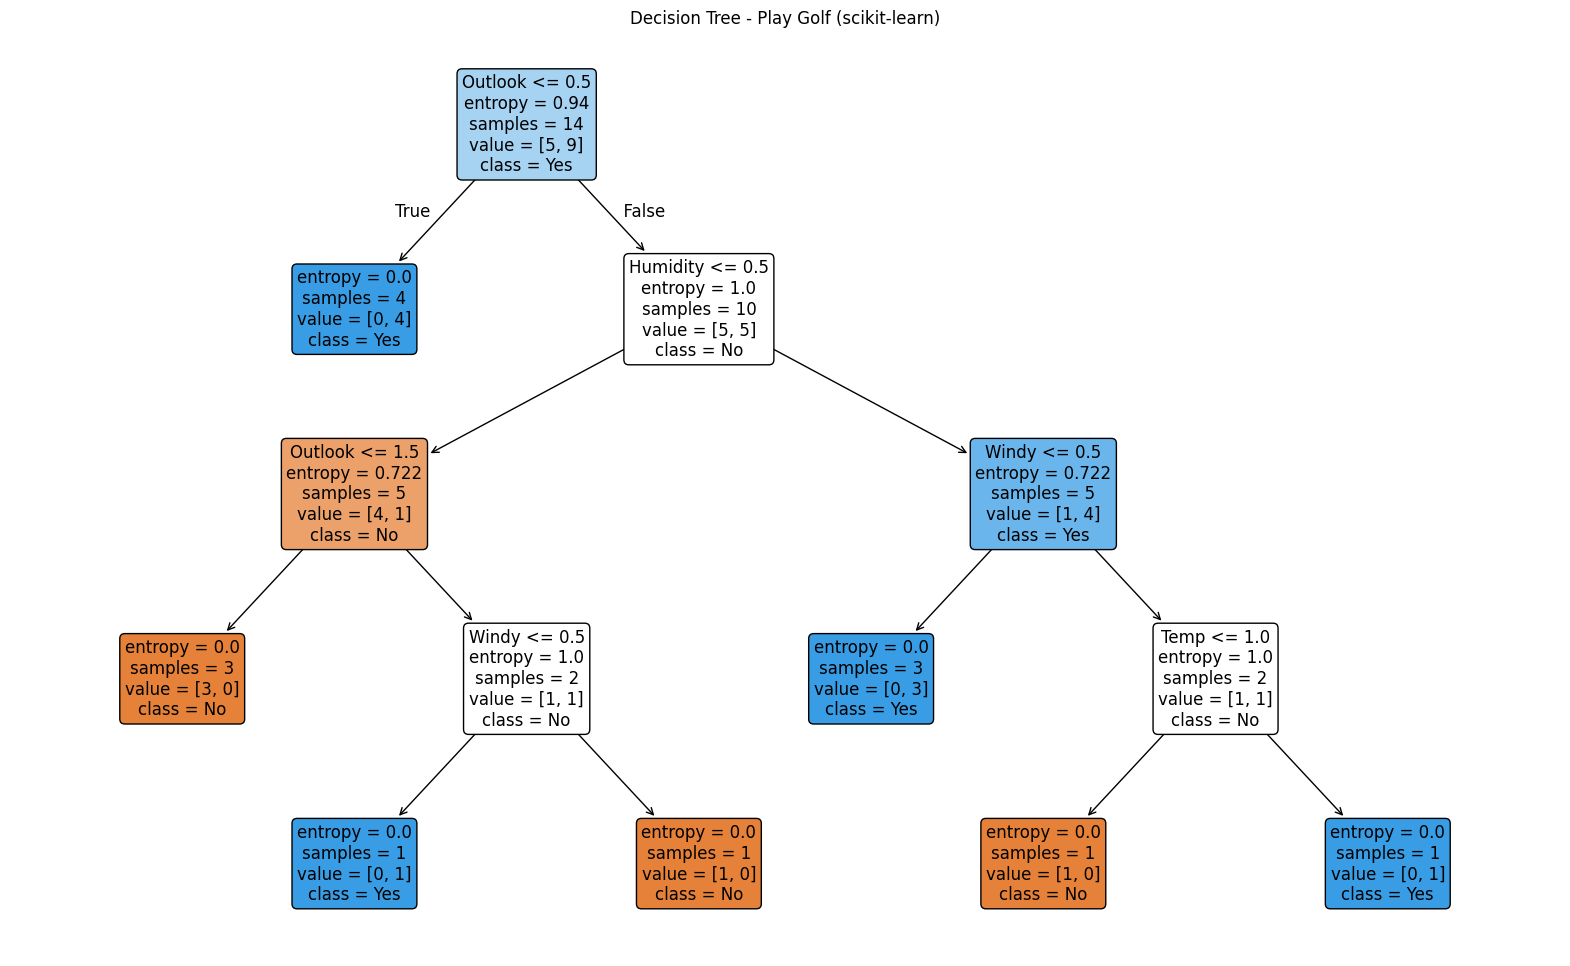

In [8]:
print("Struktur Pohon (Versi Gambar):")

# Cetak struktur pohon (versi gambar)
plt.figure(figsize=(20, 12))
plot_tree(clf,
          feature_names=feature_names,
          class_names=class_names,
          filled=True,
          rounded=True,
          fontsize=12)
plt.title("Decision Tree - Play Golf (scikit-learn)")
plt.show()